In [2]:
from qiskit.transpiler.coupling import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger
from mirror_gates.sqiswap_decomposer import SiSwapDecomposePass
from qiskit.transpiler.passmanager import PassManager
from qiskit import Aer, transpile
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    pauli_error,
    depolarizing_error,
    thermal_relaxation_error,
    RelaxationNoisePass,
)
from qiskit.circuit import Delay
from qiskit.transpiler.passes import PadDelay, ASAPSchedule
from qiskit import QuantumCircuit

In [3]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

Loading qft_n8 from QiskitCircuitInterface


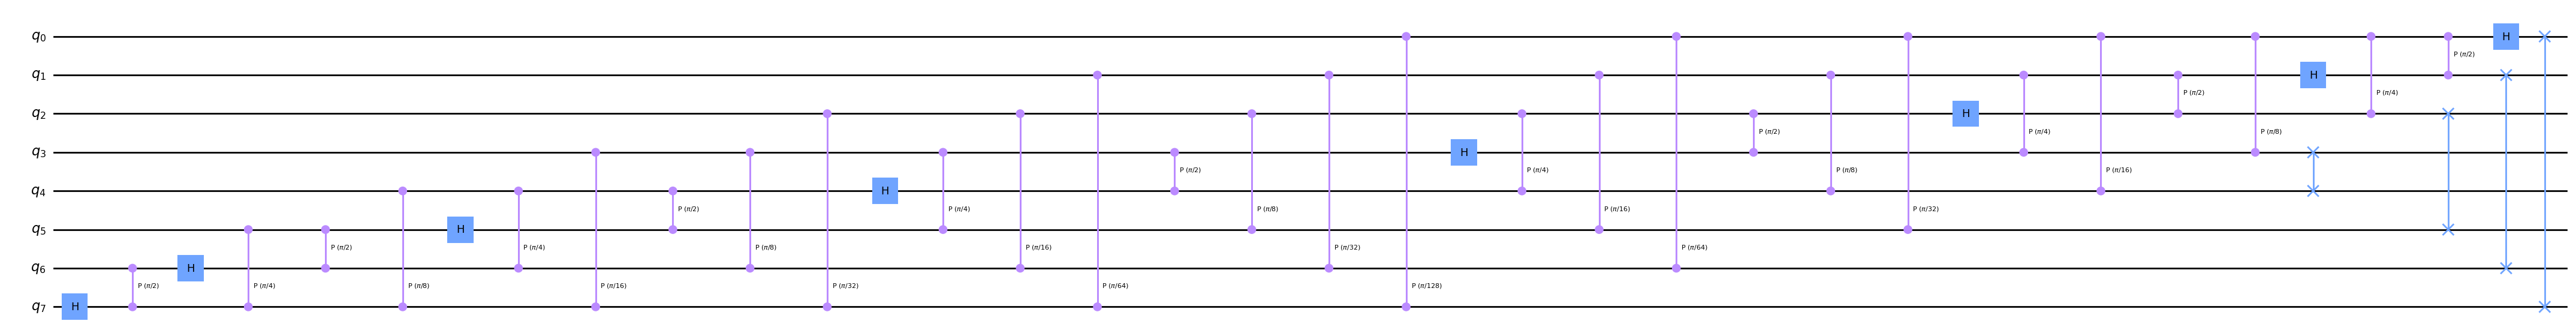

In [4]:
# from transpile_benchy.interfaces.mqt_interface import MQTBench
from transpile_benchy.interfaces.qasm_interface import QASMBench
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary(circuit_list=[])
qc = lib.get_circuit("qft_n8")
qc = qc.decompose()
display(qc.draw("mpl", fold=-1))

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 2.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 3.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)


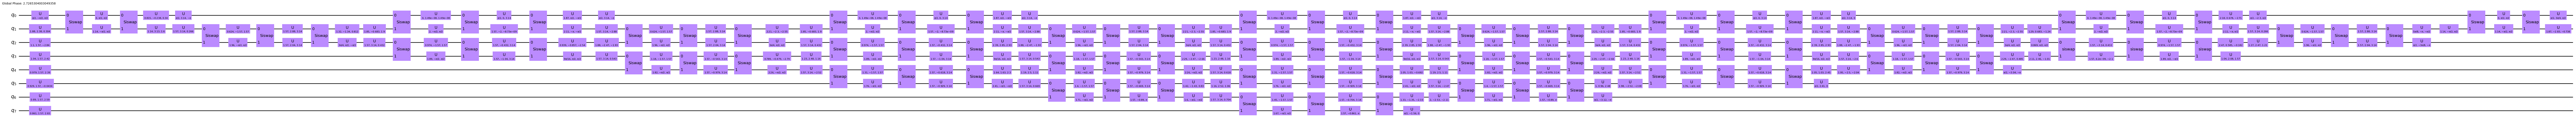

In [4]:
runner = Mirage(
    coupling_map,
    cx_basis=0,
    parallel=0,
    logger=transpile_benchy_logger,
    cost_function="depth",
    # cost_function="basic",
    anneal_routing=True,
    layout_trials=20,
    fb_iters=4,
    # layout_trials=20,
    # fb_iters=4,
    # fixed_aggression=0
    # cost_function="basic",
    use_fast_settings=1,
)

routed = runner.run(qc)
decomposer = PassManager()
decomposer.append(SiSwapDecomposePass())
mirage_output = decomposer.run(routed)
mirage_output.draw("mpl", fold=-1)

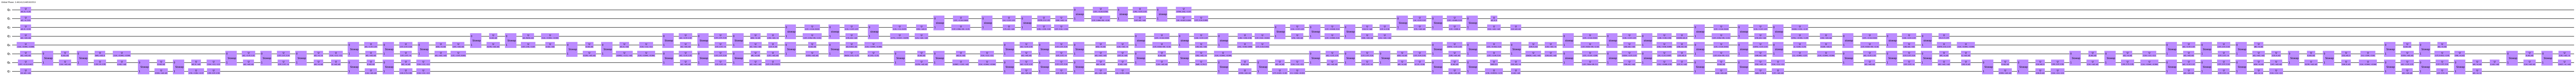

In [5]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
routed = runner.run(qc)
decomposer = PassManager()
decomposer.append(SiSwapDecomposePass())
qiskit_output = decomposer.run(routed)
qiskit_output.draw("mpl", fold=-1)

Fidelity: 0.949, Duration: 2800.000


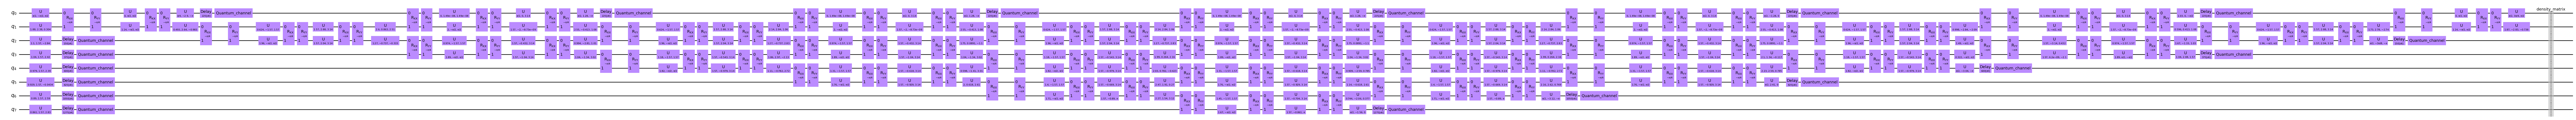

Fidelity: 0.949, Duration: 4300.000


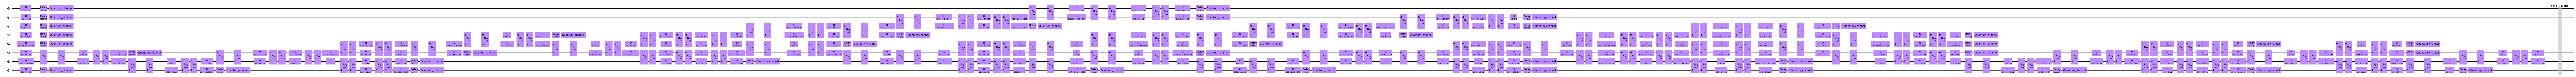

In [6]:
from mirror_gates.noisy_fidelity import get_noisy_fidelity

a, b, c = get_noisy_fidelity(mirage_output, coupling_map)
print(f"Fidelity: {a:.3f}, Duration: {b:.3f}")
display(c.draw("mpl", fold=-1))

a, b, c = get_noisy_fidelity(qiskit_output, coupling_map)
print(f"Fidelity: {a:.3f}, Duration: {b:.3f}")
display(c.draw("mpl", fold=-1))